In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
import networkx as nx
import pandas as pd
from tqdm import tqdm

import csv

import os

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, plot_style, util

In [2]:
os.getcwd()

'c:\\Users\\caele\\Desktop\\Spring2025\\miller-lab-final\\figures\\figure1'

In [3]:
# load data from csv
df = pd.read_csv('figure1_RSO_data_v2.csv', header=0, index_col=None)
df.head()

,pset,amp-dur
0,[ 1.00000000e-02 1.00000000e-02 0.00000000e+...,"[(3.42, 0.00207), (3.42, 0.00264), (3.42, 0.00..."
1,[ 1.00000000e-02 1.00000000e-02 0.00000000e+...,"[(1.3, 0.001), (1.3, 0.00127), (1.3, 0.00162),..."
2,[ 1.00000000e-02 1.00000000e-02 0.00000000e+...,"[(18.49, 0.00162), (18.49, 0.00207), (18.49, 0..."
3,[ 1.00000000e-02 1.00000000e-02 0.00000000e+...,"[(8.97, 0.00886), (8.97, 0.01129), (8.97, 0.01..."
4,[ 1.00000000e-02 1.00000000e-02 0.00000000e+...,"[(5.54, 0.00127), (5.54, 0.00162), (5.54, 0.00..."


In [5]:
pset_str = df.iloc[0, 0]

In [6]:
pset = np.array([float(p) for p in pset_str.removeprefix('[').removesuffix(']').split()])
tauE, tauI, _, _, _, _, _, _, WEE, WEI, WIE, WII, thetaE, thetaI = network_model.unpack_parameters(pset)

In [7]:
df.iloc[0, 1]

'[(3.42, 0.00207), (3.42, 0.00264), (3.42, 0.00336), (3.42, 0.00428), (3.42, 0.00546), (3.42, 0.00695), (3.42, 0.00886), (3.42, 0.01129), (3.42, 0.01438), (3.42, 0.01833), (3.42, 0.02336), (3.42, 0.02976), (3.42, 0.03793), (3.42, 0.04833), (3.42, 0.06158), (3.42, 0.07848), (3.42, 0.1), (4.35, 0.00127), (4.35, 0.00162), (4.35, 0.00207), (4.35, 0.00264), (4.35, 0.00336), (4.35, 0.00428), (4.35, 0.00546), (4.35, 0.00695), (4.35, 0.00886), (4.35, 0.01129), (4.35, 0.01438), (4.35, 0.01833), (4.35, 0.02336), (4.35, 0.02976), (4.35, 0.03793), (4.35, 0.04833), (4.35, 0.06158), (4.35, 0.07848), (4.35, 0.1), (5.54, 0.001), (5.54, 0.00127), (5.54, 0.00162), (5.54, 0.00207), (5.54, 0.00264), (5.54, 0.00336), (5.54, 0.00428), (5.54, 0.00546), (5.54, 0.00695), (5.54, 0.00886), (5.54, 0.01129), (5.54, 0.01438), (5.54, 0.01833), (5.54, 0.02336), (5.54, 0.02976), (5.54, 0.03793), (5.54, 0.04833), (5.54, 0.06158), (5.54, 0.07848), (5.54, 0.1), (7.04, 0.001), (7.04, 0.00127), (7.04, 0.00162), (7.04, 0.00

In [8]:
def bistable_no_depression(stimulus_timing, stimulus_duration, stimulus_amplitude, duration, dt, initial_conditions=[0, 0]):
    rmax = 100

    IappI = np.zeros(int(duration/dt))
    IappE = np.zeros(int(duration/dt))
    IappE[int(stimulus_timing/dt):int((stimulus_timing+stimulus_duration)/dt)] = stimulus_amplitude
    IappI[int(stimulus_timing/dt):int((stimulus_timing+stimulus_duration)/dt)] = stimulus_amplitude

    rE, rI = network_model.simulateISP(dt, duration, rmax, tauE, tauI, 
                            WEE, WEI, WIE, WII, thetaE, thetaI,
                            IappI, IappE, rE0=initial_conditions[0], rI0=initial_conditions[1])   
    
    return rE, rI

In [9]:
def get_basins(amplitude, n=500):
    dt = 1e-4

    # meshgrid for initial conditions
    x = np.linspace(0, 20, n) # rE0
    y = np.linspace(0, 20, n) # rI0
    X, Y = np.meshgrid(x, y)
    X_, Y_ = X.ravel(), Y.ravel()

    # find final states for each initial condition
    final_states = np.zeros((n*n, 2))
    duration = 6
    for j, (rE0, rI0) in enumerate(zip(X_, Y_)):
        rE, rI = bistable_no_depression(0, duration, amplitude, duration, dt, initial_conditions=[rE0, rI0])
        final_states[j] = [rE[-1], rI[-1]]
        
    # find unique steady states
    steady_states, indices = np.unique(np.round(final_states,1), axis=0, return_index=True)
    steady_states = final_states[indices]
    
    # map final states to steady states for colormap
    color_mappings = np.ones((n*n))*-1 # will break the colormap if any -1s are left (intended behavior)
    for i, state in enumerate(final_states):
        for j, steady_state in enumerate(steady_states):
            if np.allclose(state, steady_state, atol=1e-1):
                color_mappings[i] = j
    
    return X, Y, color_mappings, steady_states

In [23]:
amp, dur = 3.42, 0.00207
timing = 0.5
off_to_on = bistable_no_depression(timing, dur, amp, 6, 1e-5)
on_to_off = bistable_no_depression(timing, dur, amp, 6, 1e-5, initial_conditions=[5, 10])

stably_on = np.all(np.abs(off_to_on[0][int((6-1)/1e-5):-1] - 5) < 0.1)
stably_off = np.all(np.abs(on_to_off[0][int((6-1)/1e-5):-1]) < 0.1)

print(f"Stably on: {stably_on}, Stably off: {stably_off}")

Stably on: True, Stably off: False


In [18]:
off_to_on[0][int((6-1)/1e-5):-1].shape

(100000,)

In [19]:
X, Y, autonomous_basins, auto_states = get_basins(0, n=10)
_, _, stimulus_basins, stim_states = get_basins(amp, n=10)

#### plotting

In [20]:
MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250

inh_blue = "#7879ff"
excit_red = '#F58E89'

In [26]:
def plot_trace(ax, traces, duration=2, dt = 1e-5):
    time = np.arange(0, duration, dt)
    ax.plot(time, traces[0], label='Excitatory', c=excit_red)
    ax.plot(time, traces[1], label='Inhibitory', c=inh_blue)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Firing Rate (Hz)')
    ax.set(xlim=(0,duration), ylim=(0,20))
    ax.axvspan(timing, timing+dur, alpha=0.5, color='0.8')
    ax.annotate(r"$I_{app}$ = " + str(amp), xy=(timing, 0), xytext=(15, 15), textcoords='offset pixels', fontsize=14, color='0.2', fontfamily='serif')
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


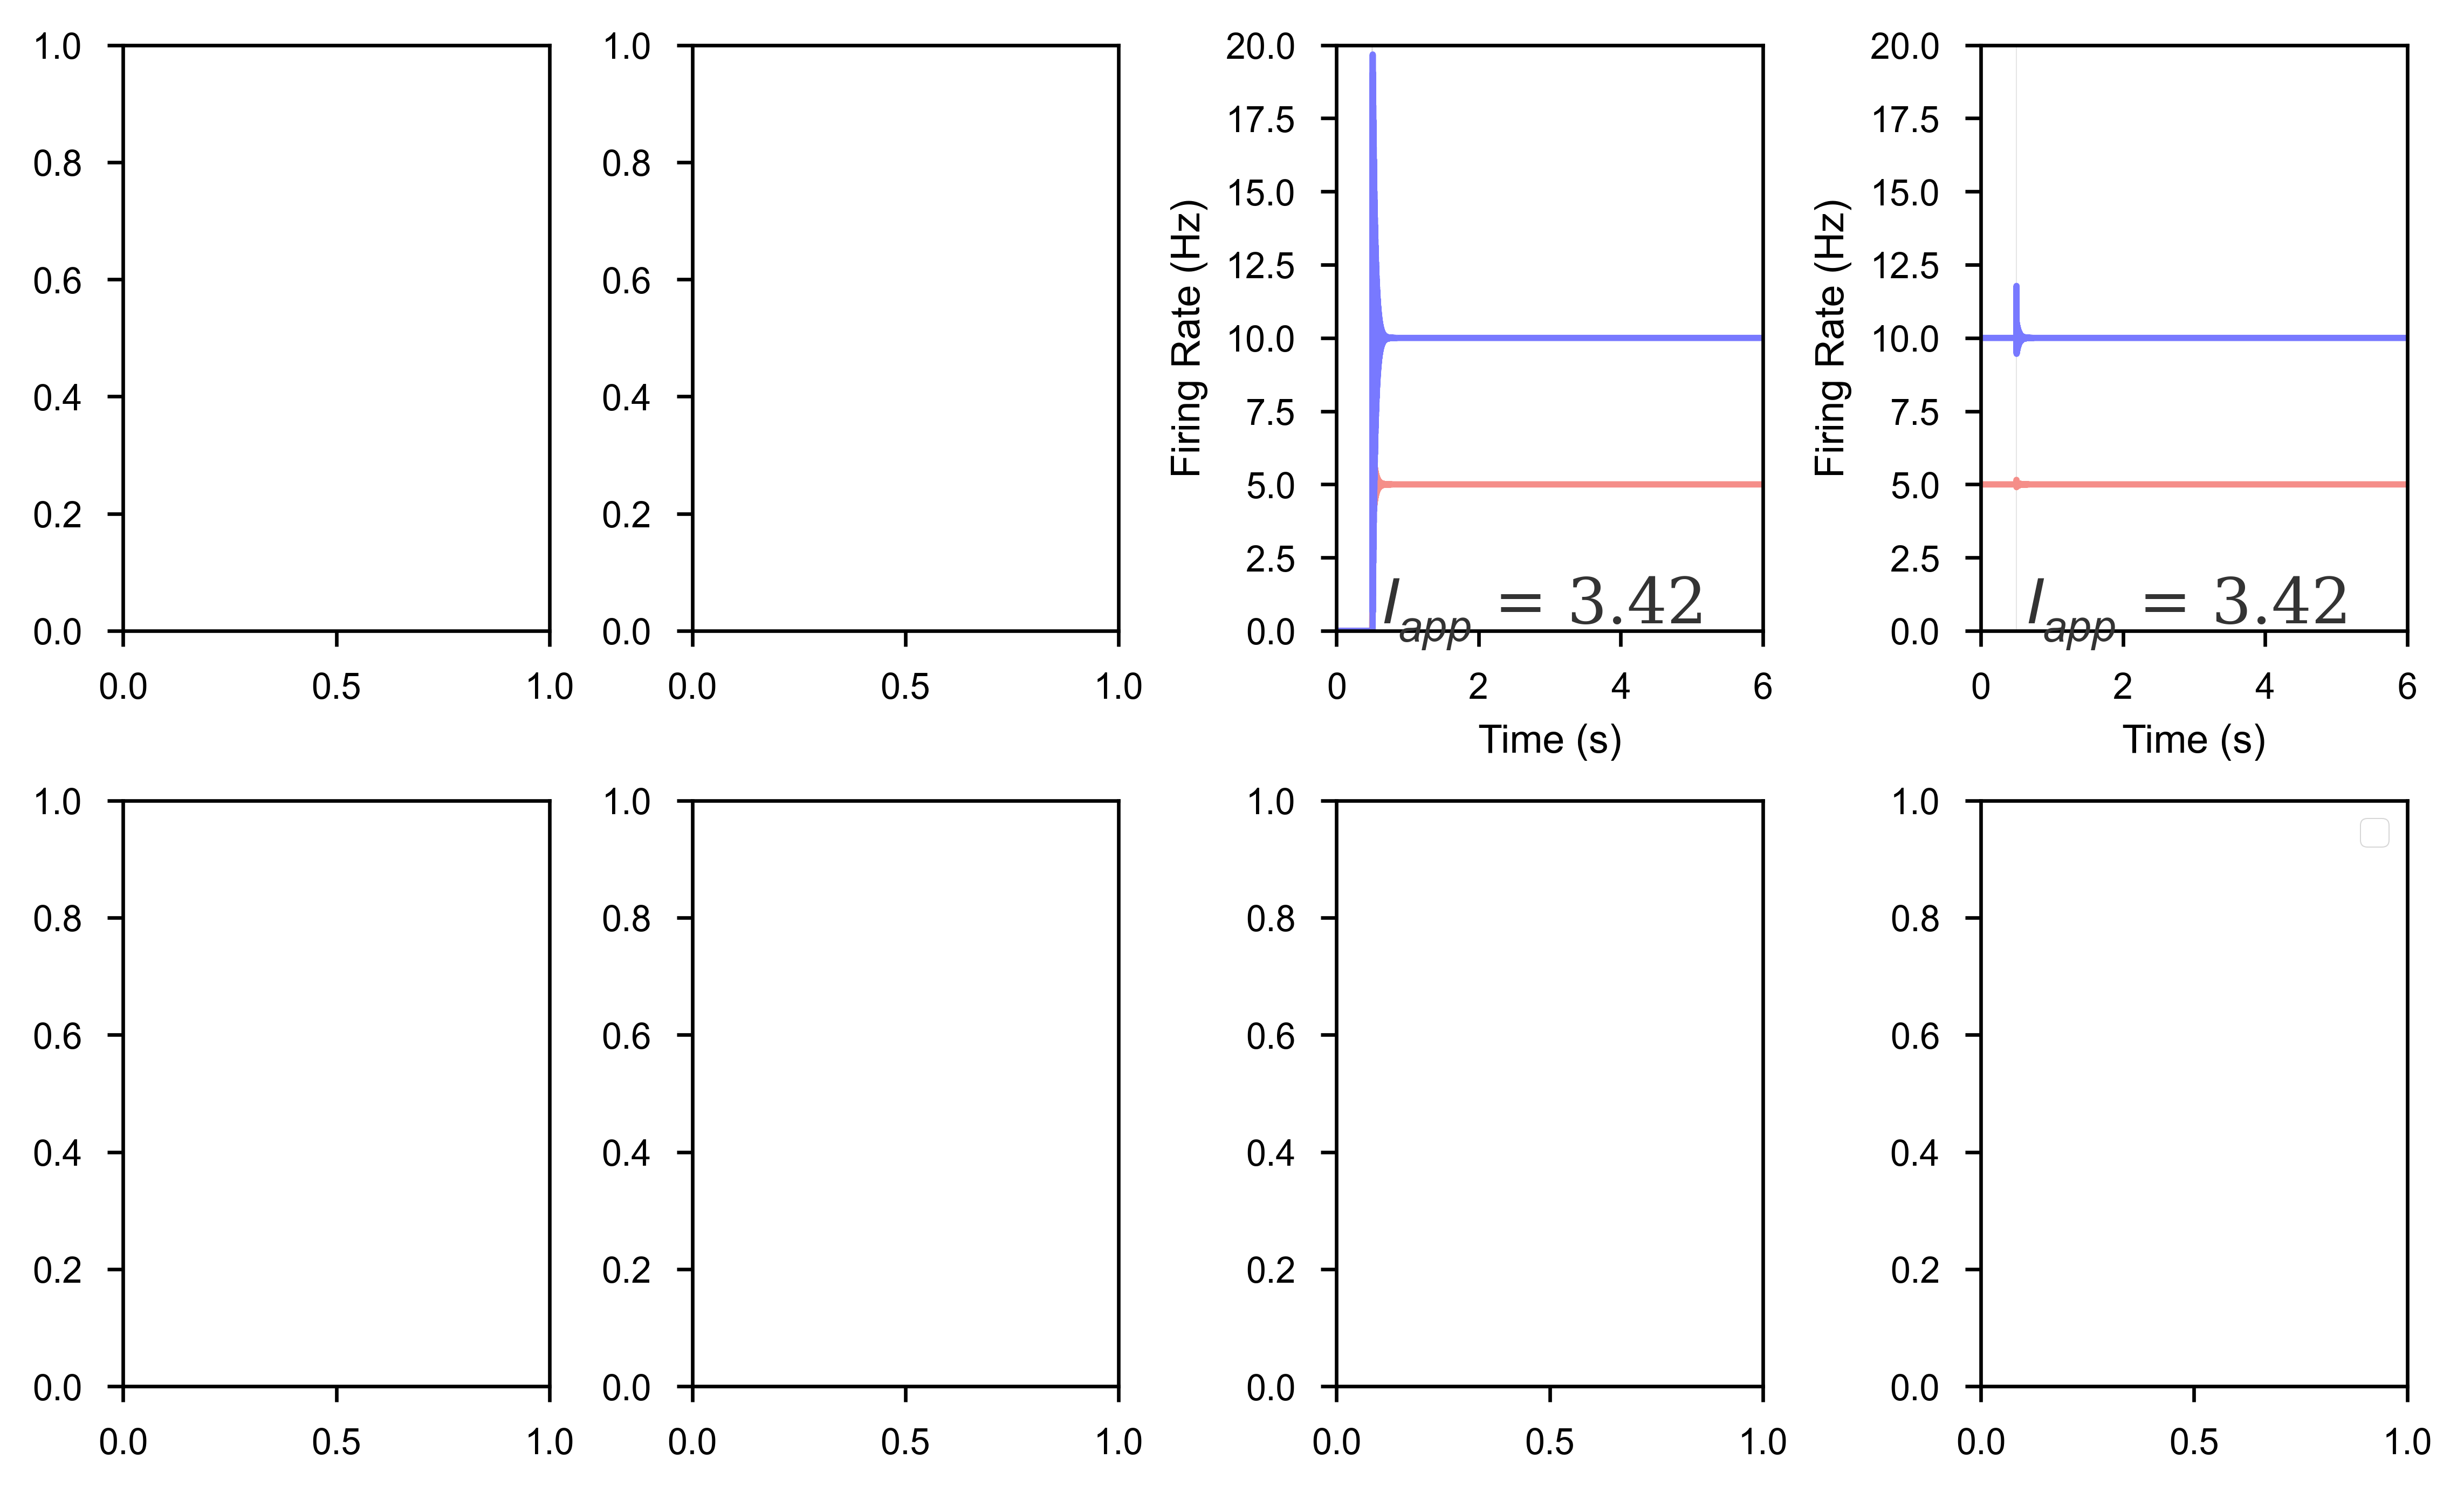

In [27]:
px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig = plt.figure(layout='constrained', figsize=(MAX_WIDTH*px, MAX_WIDTH*px*0.6))
axd = fig.subplot_mosaic(
    """
    ABCD
    EFGH
    """
)
plot_trace(axd['C'], off_to_on, duration=6)
plot_trace(axd['D'], on_to_off, duration=6)
# for i, ax in axd.keys():
#     if i % 2 == 0:
#         ax.countourf(X, Y)
#     else:
        

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3.5), layout='tight')

for i, ax in enumerate(axs.flat):


for i, ax in enumerate(axs.flat):
    # plot phase plane
    ax.contourf(X, Y, color_mappings.reshape(n, n), levels=len(steady_states), cmap='Pastel1')
    ax.set(xlabel="$r_{E}$", ylabel="$r_{I}$")
    ax.set_xlim([-0.25, 20.25])
    ax.set_ylim([-0.25, 20.25])
    # plot steady states
    ax.scatter(steady_states[:, 0], steady_states[:, 1], c='k', s=50, marker='x', label='stable nodes', zorder=10)
    
    # stimulus steady state(s)
    rE_stim, rI_stim = bistable_no_depression(0, duration, stimulus_amplitudes[i], duration, dt, initial_conditions=[10, 10])
    ax.scatter(rE_stim[-1], rI_stim[-1], c='r', s=50, marker='x', label='stim. stable node(s)', zorder=10)
    if i == 3: ax.scatter(0, 0, c='r', s=50, marker='x', zorder=5)
    
    # plot trajectories
    rE, rI = bistable_no_depression(0.5, stimulus_durations[i], stimulus_amplitudes[i], duration, dt)
    rE2, rI2 = bistable_no_depression(0.5, stimulus_durations[i], stimulus_amplitudes[i], duration, dt, initial_conditions=[9.571, 4.428])
    
    ax.plot(rE[:int(stimulus_onset/dt)], rI[:int(stimulus_onset/dt)], 'b',lw=1.5)
    ax.plot(rE[int(stimulus_onset/dt):int((stimulus_onset+stimulus_durations[i])/dt)], rI[int(stimulus_onset/dt):int((stimulus_onset+stimulus_durations[i])/dt)], 
            'r--', lw=1.5,
            label='stim. ON')
    ax.plot(rE[int((stimulus_onset+stimulus_durations[i])/dt):], rI[int((stimulus_onset+stimulus_durations[i])/dt):], 'b', lw=1.5, label='stim. OFF')

    ax.plot(rE2[:int(stimulus_onset/dt)], rI2[:int(stimulus_onset/dt)], 'b',lw=1.5)
    ax.plot(rE2[int(stimulus_onset/dt):int((stimulus_onset+stimulus_durations[i])/dt)], rI2[int(stimulus_onset/dt):int((stimulus_onset+stimulus_durations[i])/dt)], 
            'r--', lw=1.5)
    ax.plot(rE2[int((stimulus_onset+stimulus_durations[i])/dt):], rI2[int((stimulus_onset+stimulus_durations[i])/dt):], 'b', lw=1.5)

    # text
    s=r'$I_{app} = $'+str(stimulus_amplitudes[i])+'\n'+r'$\tau_{dur} = $'+str(stimulus_durations[i])
    ax.text(19, 0.25, s=s, ha='right', va='bottom', fontsize=12) # stimulus info
    ax.text(19, 19, s=transition_types[i], ha='right', va='top', fontsize=18) # transition type
    
    if i == 0:
        ax.legend(loc='upper left')
    
plt.show()